- BATCH_SIZE = 256 -> 128
- IMAGE_SIZE = 32 -> 64
- 생성자에서 업샘플링 레이어 추가
- 판별자에서 다운샘플링 레이어 추가
- 옵티마이저는 Adam 동일

### 필요 라이브러리 및 데이터셋 로드

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
train_x = tf.image.resize(train_x, [64,64])
train_x.shape

TensorShape([50000, 64, 64, 3])

###  데이터 전처리
- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [4]:
# Train_x 정규화
train_x = (train_x.numpy().astype(np.float32) - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- 로드한 학습 데이터를 시각화를 통해 확인

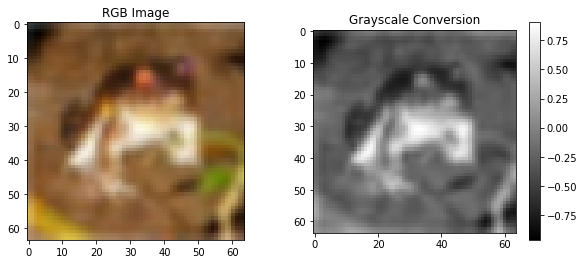

In [5]:
import matplotlib.pyplot as plt

# RGB 채널 유지 시각화
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow((train_x[0] * 127.5 + 127.5).astype('uint8'))  # 역정규화
plt.title('RGB Image')

# 그레이스케일 변환 시각화
plt.subplot(1,2,2)
plt.imshow(train_x[0].mean(axis=2), cmap='gray')  # 채널 평균 계산
plt.title('Grayscale Conversion')
plt.colorbar()
plt.show()


- BATCH_SIZE = 256 -> 128

In [6]:
BUFFER_SIZE = 50000 # 학습할 데이터의 양
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 생성자 모델 구현
- (64, 64, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수
- 업샘플링 추가
- alpha를 0.2로 설정하면 음수 입력도 0.2배로 통과시켜 뉴런이 완전히 죽지 않고 일부 신호를 계속 전달
- 음수 입력이란 입력값과 가중치의 곱을 모두 더한 뒤 편향을 더한 값이 0보다 작은 값

In [7]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((8, 8, 512)),
        
        # 8x8 → 16x16
        layers.Conv2DTranspose(256, 5, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        # 16x16 → 32x32
        layers.Conv2DTranspose(128, 5, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        # 32x32 → 64x64
        layers.Conv2DTranspose(64, 5, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        # 최종 출력
        layers.Conv2DTranspose(3, 5, strides=1, padding='same', 
                             activation='tanh')
    ])
    return model


In [8]:
generator = make_generator()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [9]:
noise = tf.random.normal([1, 100])  # 배치 크기 1, 노이즈 차원 100 [4]

generated_image = generator(noise, training=False)
print("생성된 이미지 차원:", generated_image.shape)

생성된 이미지 차원: (1, 64, 64, 3)


### 판별자 모델 구현
- 다운샘플링 추가

In [10]:
def make_discriminator():
    return tf.keras.Sequential([
        # 입력층 크기 변경 (64x64)
        layers.Conv2D(64, 5, strides=2, padding='same', 
                     input_shape=(64,64,3)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])

In [11]:
discriminator = make_discriminator()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

- 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [12]:
# 생성자 모델 인스턴스화
generator = make_generator()

# 노이즈 입력 생성
noise = tf.random.normal([1, 100])

# 이미지 생성 및 판별
generated_image = generator(noise, training=False)
discriminator_result = discriminator(generated_image)

# 0에 가까울수록 가짜로 판단
print("판별 결과:", discriminator_result.numpy())

판별 결과: [[0.00015989]]


### 손실함수(loss function)

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자와 판별자의 손실함수(loss)를 구현
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

# 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)
- 생성자와 판별자를 최적화하는 optimizer를 정의

In [14]:
# Adam 최적화 기법 활용
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 훈련과정 상세 기능 구현
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

In [15]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현

In [16]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_2/train_history_2_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- training_checkpoints_2 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [18]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 위에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행

In [19]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [20]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

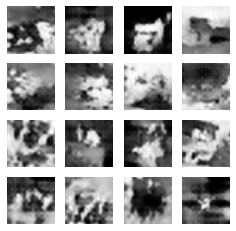

Time for training : 6120 sec


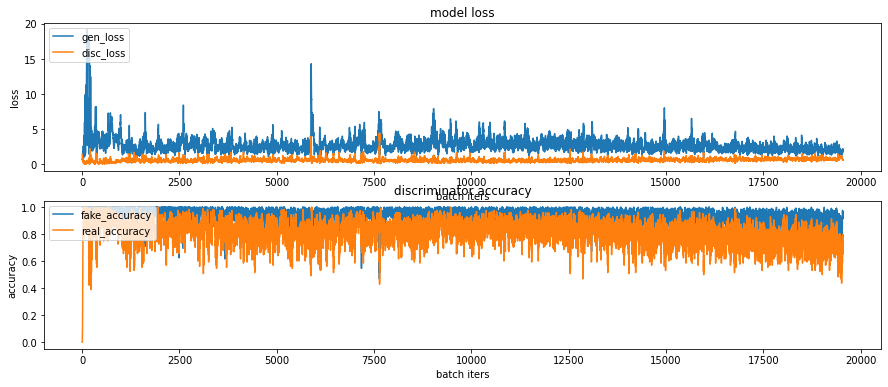

CPU times: user 1h 42min 56s, sys: 2min 37s, total: 1h 45min 34s
Wall time: 1h 42min 1s


In [21]:
%%time
train(train_dataset, EPOCHS, save_every)

- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현

In [23]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan_improvement.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan_improvement.gif

-rw-r--r-- 1 root root 1645848 Apr 17 07:59 /aiffel/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan_improvement.gif


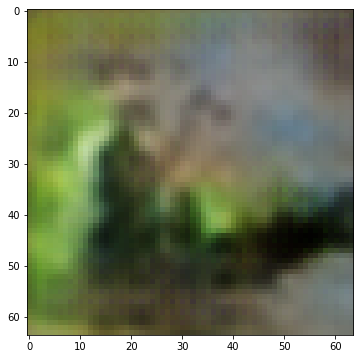

In [42]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.